In [1]:
import os, fiona, glob
import geopandas as gpd
import pandas as pd
from rasterio.crs import CRS
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

In [2]:
# Every time you change something within the code cell, run it once more to update the variable.

BOUNDS = [39.7299, -77.5886, 36.9909, -81.6319] # In decimal coordinate form.  Format: [N, E, S, W].  Select the smallest area possible in your analyses for maximum resoultion!  

API_KEY = '9086887f175d33aa72eda767f5b1e9cd' # Get your API key from opentopography.org.  Students get higher resolution data!

DEM_DATASET = 'USGS30m' # Options are USGS30m, USGS10m, & USGS1m.  Be warned!  As resolution goes up, available download area goes down.

PROJ_TITLE = 'wv_tot' # Create a succinct name with no spaces or leading digits to represent your project file for future exports.

PATH = os.getcwd()

In [3]:
dir = f'{PATH}/{PROJ_TITLE}/GeoDatabases'
path_list = glob.glob(f'{dir}/*.zip')
master_dip_gdf = gpd.GeoDataFrame()
master_geol_gdf = gpd.GeoDataFrame()
for path in path_list:
    valid_layers = []
    try:
        layers = fiona.listlayers(path)
        for layer in layers:
            if 'BED' in layer:
                valid_layers.append(layer)
            if 'CNT_poly' in layer or 'CNT_POLY' in layer:
                valid_layers.append(layer)
            gdf = gpd.read_file(path, layer=valid_layers[0])
            gdf.columns = gdf.columns.str.lower()
            master_dip_gdf = pd.concat([master_dip_gdf, gdf], ignore_index=True)
            try:
                gdf2 = gpd.read_file(path, layer = valid_layers[1])
                gdf2.columns = gdf2.columns.str.lower()
                master_geol_gdf= pd.concat([master_geol_gdf, gdf2], ignore_index=True)
            except Exception as e:
                print(f'No geology layer, {e}')
    except Exception as e:
        print(f'An error occured: {e}')

In [4]:
master_dip_gdf = master_dip_gdf[['dip_angle', 'dip_direct', "geometry"]].to_crs(CRS.from_epsg(2283))
master_dip_gdf.plot()

KeyError: "None of [Index(['dip_angle', 'dip_direct', 'geometry'], dtype='object')] are in the [columns]"

In [ ]:
master_geol_gdf = master_geol_gdf[['unit_abbrv', 'geometry', 'symbol']].to_crs(CRS.from_epsg(2283))
display(master_geol_gdf)

,unit_abbrv,geometry,symbol
0,Dmt,"MULTIPOLYGON (((11574806.845 7300828.101, 1157...",NaN
1,Dbh,"MULTIPOLYGON (((11577427.749 7300346.097, 1157...",NaN
2,Dmn,"MULTIPOLYGON (((11534531.853 7209869.177, 1153...",NaN
3,Dbh,"MULTIPOLYGON (((11592212.912 7296278.82, 11592...",NaN
4,Do,"MULTIPOLYGON (((11534088.245 7210222.759, 1153...",NaN
...,...,...,...
16270,Sto,"MULTIPOLYGON (((11211803.742 6868122.501, 1121...",NaN
16271,Dmn,"MULTIPOLYGON (((11232587.952 6867316.337, 1123...",NaN
16272,Oo,"MULTIPOLYGON (((11199930.698 6878396.05, 11199...",NaN
16273,Do,"MULTIPOLYGON (((11232871.039 6897080.859, 1123...",NaN


In [ ]:
from pyproj import Proj, transform
import numpy as np

kp_dip_fin = gpd.GeoDataFrame()
kp_geol_fin = gpd.GeoDataFrame()

ksn_paths = glob.glob(f'{PATH}/{PROJ_TITLE}/lsht_kps/*.csv')
for csv in ksn_paths:
    csv_name = csv.split(sep='/')[-1]
    wshed_name = csv_name[0:-23]
    ksn_df = pd.read_csv(csv, index_col=0)
    delta_ksn = np.abs(np.asarray(ksn_df['delta_ksn']))
    high_ksn = [x > np.percentile(delta_ksn, 90) for x in delta_ksn]
    ksn_df['kp'] = high_ksn
    in_proj = Proj(init='epsg:2283')
    out_proj = Proj(init='epsg:4269')
    easting = ksn_df.x.values
    northing = ksn_df.y.values
    longitude, latitude = transform(in_proj, out_proj, easting, northing)
    ksn_df['longitude'] = longitude
    ksn_df['latitude'] = latitude
    ksn_df['wshed'] = [wshed_name]*len(ksn_df)
    ksn_df_masked = ksn_df[ksn_df.kp == True][['chi', 'delta_ksn', 'elevation', 'x', 'y', 'longitude', 'latitude', 'wshed']]
    final_kp_df = gpd.GeoDataFrame(data=ksn_df_masked, geometry= gpd.points_from_xy(ksn_df_masked.x, ksn_df_masked.y), crs=CRS.from_epsg(2283))
    kp_dip = gpd.sjoin_nearest(final_kp_df, master_dip_gdf, max_distance=300, distance_col='dist_from_dip')
    kp_geol = gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=300, distance_col='dist_from_geol')
    kp_dip_fin = pd.concat([kp_dip_fin, kp_dip], ignore_index=True)
    kp_geol_fin = pd.concat([kp_geol, kp_geol_fin], ignore_index=True)


In [43]:
# voilin plot per watershed, bins dip angle, width by elevation count
kp_dip_fin
# sns.histplot(data=kp_dip_fin, x='dip_angle')

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip
0,7.309960,61.95304,501.40012,11276488.0,6966856.5,-79.224108,38.777070,North_Fork_South_Branch_Potomac_River,POINT (11276488 6966856.5),141650,17,97,189.040746
1,7.309960,61.95304,501.40012,11276488.0,6966856.5,-79.224108,38.777070,North_Fork_South_Branch_Potomac_River,POINT (11276488 6966856.5),141268,17,97,189.040746
2,7.309960,61.95304,501.40012,11276488.0,6966856.5,-79.224108,38.777070,North_Fork_South_Branch_Potomac_River,POINT (11276488 6966856.5),140886,17,97,189.040746
3,7.309960,61.95304,501.40012,11276488.0,6966856.5,-79.224108,38.777070,North_Fork_South_Branch_Potomac_River,POINT (11276488 6966856.5),140695,17,97,189.040746
4,7.309960,61.95304,501.40012,11276488.0,6966856.5,-79.224108,38.777070,North_Fork_South_Branch_Potomac_River,POINT (11276488 6966856.5),141077,17,97,189.040746
...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,7.867512,-50.51133,499.66580,11306842.0,7001499.5,-79.118455,38.872798,South_Mill_Creek-Mill_Creek,POINT (11306842 7001499.5),142797,45,292,243.058663
633,7.867512,-50.51133,499.66580,11306842.0,7001499.5,-79.118455,38.872798,South_Mill_Creek-Mill_Creek,POINT (11306842 7001499.5),142422,45,292,243.058663
634,7.867512,-50.51133,499.66580,11306842.0,7001499.5,-79.118455,38.872798,South_Mill_Creek-Mill_Creek,POINT (11306842 7001499.5),142922,45,292,243.058663
635,7.867512,-50.51133,499.66580,11306842.0,7001499.5,-79.118455,38.872798,South_Mill_Creek-Mill_Creek,POINT (11306842 7001499.5),143172,45,292,243.058663


<Axes: title={'center': 'Elevation vs dip angle of underlying rock unit of knickpoints for wv_lower, [38.985453, -78.975131, 38.336868, -80.04401]'}, xlabel='dip_angle', ylabel='elevation'>

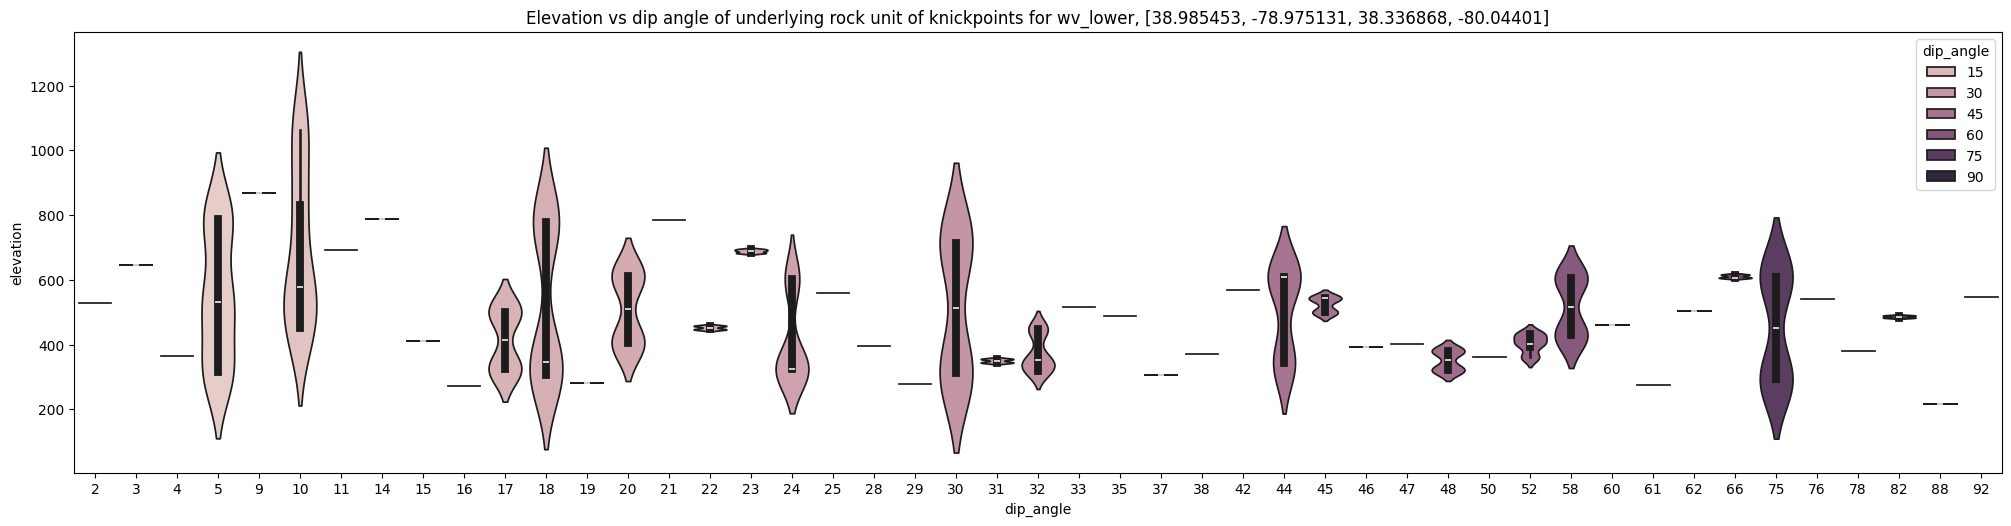

In [44]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,5))
fig.tight_layout()
ax.set_title(f'Elevation vs dip angle of underlying rock unit of knickpoints for {PROJ_TITLE}, {BOUNDS}')
sns.violinplot(data=kp_dip_fin, x='dip_angle', y='elevation', hue='dip_angle', ax=ax)

<Axes: title={'center': 'Elevation vs underlying rock unit of knickpoints for wv_data, [39.4799, -78.467, 38.393, -80.2704]'}, xlabel='unit_abbrv', ylabel='elevation'>

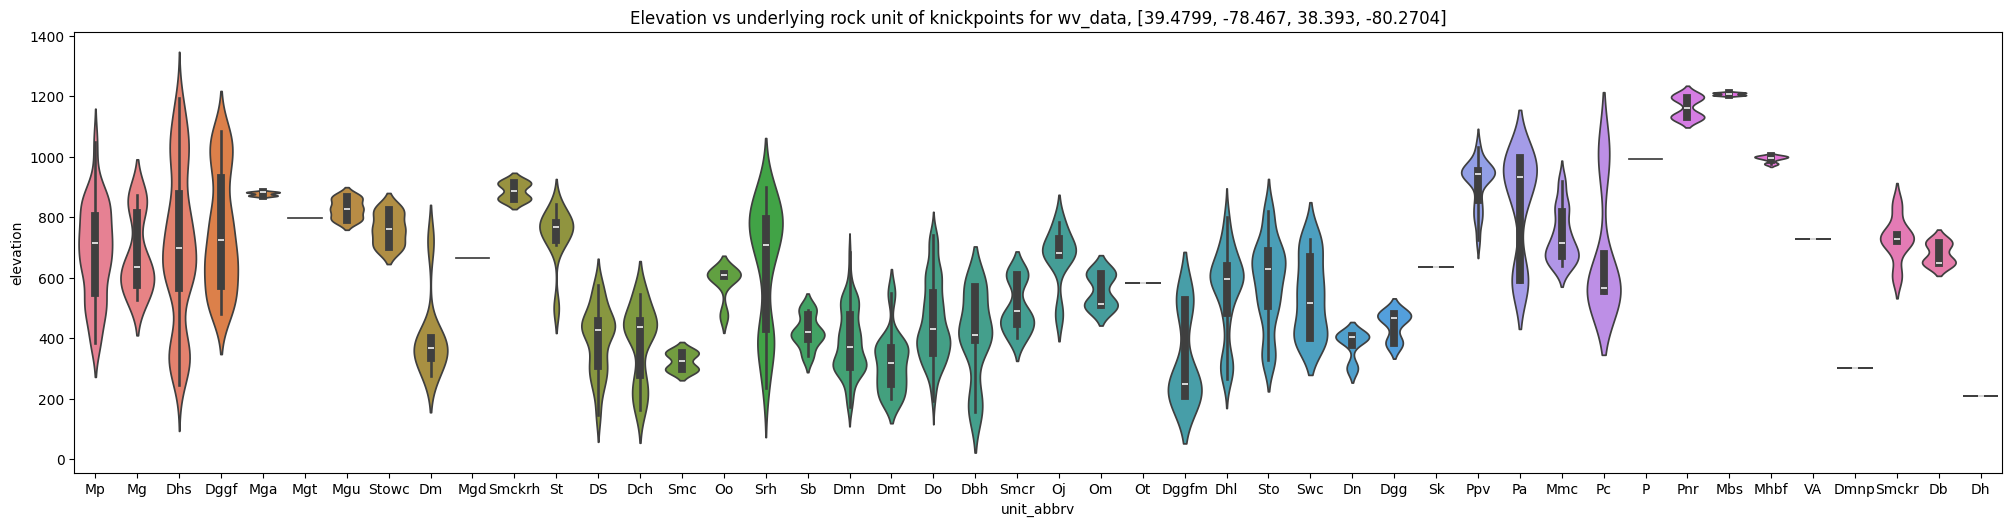

In [35]:
kp_geol_fin = kp_geol_fin[kp_geol_fin.unit_abbrv != ' ']
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,5))
fig.tight_layout()
ax.set_title(f'Elevation vs underlying rock unit of knickpoints for {PROJ_TITLE}, {BOUNDS}')
sns.violinplot(data=kp_geol_fin, x='unit_abbrv', y='elevation', hue='unit_abbrv', ax=ax)